In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sqlalchemy as db
import pandas as pd

In [2]:
engine = db.create_engine("sqlite:///mta_data.db")

In [3]:
df = pd.read_sql("SELECT * FROM mta_data;", engine)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3508369 entries, 0 to 3508368
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 294.4+ MB


In [5]:
def get_daily_counts(row, max_counter, turnstile_direction):
    count_name = turnstile_direction
    prev_count_name = f"PREV_{turnstile_direction}"
    counter = row[count_name] - row[prev_count_name]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0?
        print(row[count_name], row[prev_count_name])
        counter = min(row[count_name], row[prev_count_name])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [40]:
import calendar

def stations_monthly(data, stations, month, year, turnstile_direction):
    data = data[data.STATION.isin(stations)]
    data.loc[:, "DATE_FORMATTED"] = pd.to_datetime(data.loc[:, "DATE"])
    data = data[(data.DATE_FORMATTED.dt.month == month) & (data.DATE_FORMATTED.dt.year == year)]
    turnstiles_daily = (data.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_FORMATTED"],as_index=False)[turnstile_direction].max())
    turnstiles_daily[["PREV_DATE", f"PREV_{turnstile_direction}"]] = turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE_FORMATTED", turnstile_direction]].shift(1)
    turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
    turnstiles_daily[f"DAILY_{turnstile_direction}"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=500000, turnstile_direction=turnstile_direction)
    print(turnstiles_daily[f"DAILY_{turnstile_direction}"].describe().apply(lambda x: '%.0f' % x))
    print(turnstiles_daily.groupby("STATION").size())
    station_totals = turnstiles_daily.groupby("STATION")[f"DAILY_{turnstile_direction}"].sum()
    return station_totals.rename(f"{calendar.month_abbr[month].upper()}_{turnstile_direction}")

In [41]:
crazy_stations = ['GRD CNTRL-42 ST', 'WALL ST', 'HOWARD BCH JFK', '161/YANKEE STAD', 'CONEY IS-STILLW', 'BLEECKER ST', '116 ST-COLUMBIA', 'FORDHAM RD', 'BRONX PARK EAST', 'BEACH 67 ST', 'SOUTH FERRY', '5 AVE', 'JAMAICA VAN WK', 'BROOKLYN BRIDGE', 'LAFAYETTE AV']

jan_21_entries = stations_monthly(df, crazy_stations, 1, 2021, "ENTRIES")
# jan_19_entries = stations_monthly(df, crazy_stations, 1, 2019, "ENTRIES")
#
# jan_21_exits = stations_monthly(df, crazy_stations, 1, 2021, "EXITS")
# jan_19_exits = stations_monthly(df, crazy_stations, 1, 2019, "EXITS")
jan_21_entries

66 500623.0
779 2844722.0
count     9417
mean       197
std        983
min          0
25%          1
50%         88
75%        245
max      65527
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
SOUTH FERRY         630
WALL ST            1500
dtype: int64


STATION
116 ST-COLUMBIA     51535.0
161/YANKEE STAD    205356.0
5 AVE               66015.0
BEACH 67 ST         23327.0
BLEECKER ST         77512.0
BRONX PARK EAST     23457.0
BROOKLYN BRIDGE     71199.0
CONEY IS-STILLW    129971.0
FORDHAM RD         287186.0
GRD CNTRL-42 ST    601823.0
HOWARD BCH JFK      31267.0
JAMAICA VAN WK      46446.0
LAFAYETTE AV        33562.0
SOUTH FERRY         66194.0
WALL ST            144744.0
Name: JAN_ENTRIES, dtype: float64

In [42]:
# jan_entries_change = (jan_21_entries - jan_19_entries) / jan_19_entries * 100
# jan_entries_change = jan_entries_change.round(1)
# jan_entries_change = jan_entries_change.rename("ENTRIES")
# jan_entries_change = jan_entries_change.sort_values(ascending=False)
# jan_entries_change

In [43]:
def station_percent_change(month, turnstile_direction, data=df, stations=crazy_stations, newer_year=2021, older_year=2019):
    newer_month_count = stations_monthly(data, stations, month, newer_year, turnstile_direction)
    older_month_count = stations_monthly(data, stations, month, older_year, turnstile_direction)

    count_change = (newer_month_count - older_month_count) / older_month_count * 100
    return count_change.round(1)

In [46]:
changes = pd.concat([station_percent_change(1, "ENTRIES"), station_percent_change(1, "EXITS")], axis=1)
changes = changes.sort_values(by="JAN_ENTRIES", ascending=False)

66 500623.0
779 2844722.0
count     9417
mean       197
std        983
min          0
25%          1
50%         88
75%        245
max      65527
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
SOUTH FERRY         630
WALL ST            1500
dtype: int64
1629 2353351.0
11 270306326.0
16 1847577.0
787 3173773.0
589826 201857085.0
count      8664
mean       1028
std        4432
min           0
25%          79
50%         628
75%        1467
max      294807
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1050
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     509
CONEY IS-STILLW     600

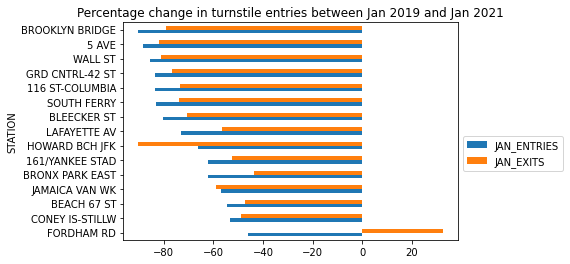

In [47]:
changes.plot.barh(title="Percentage change in turnstile entries between Jan 2019 and Jan 2021").legend(bbox_to_anchor=(1,0.5))